In [1]:
import numpy as np
from numpy.linalg import matrix_power, matrix_rank
import matplotlib.pyplot as plt
import itertools
import galois
from mec import make_circle
import seaborn as sns
from scipy.sparse import csr_matrix

In [2]:
codes = [
    [6,6,3,1,2,3,1,2],
    [15,3,9,1,2,0,2,7],
    [9,6,3,1,2,3,1,2],
    [12,6,3,1,2,3,1,2],
    [12,12,3,2,7,3,1,2],
    [30,6,9,1,2,3,25,26],
    [21,18,3,10,17,5,3,19]
]
code = codes[5]
# code = [18,12,1,11,3,2,15,1]
# code = [28,14,26,6,8,7,9,20]
code = [4,4,3,1,2,3,1,2]

In [3]:
def cyclic_shift_matrix(l):
    arr = np.eye(l, dtype=int)
    return np.roll(arr, axis=1, shift=1)

ell = code[0]
m = code[1]

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

In [4]:
A1 = matrix_power(x, code[2])
A2 = matrix_power(y, code[3])
A3 = matrix_power(y, code[4])
A = ( A1 + A2 + A3 ) % 2

B1 = matrix_power(y, code[5])
B2 = matrix_power(x, code[6])
B3 = matrix_power(x, code[7])
B = ( B1 + B2 + B3 ) % 2

In [5]:
Hx = np.hstack([A, B]).astype(int)
Hz = np.hstack([B.T, A.T]).astype(int)
# H = np.vstack([Hx, Hz])

In [7]:
GF = galois.GF(2)
arr = GF(Hz.T)
print(f"k = {2 * (Hz.T.shape[1] - matrix_rank(arr))}")

k = 0


In [8]:
def has_toric_layout():
    # As = [A1 @ A2.T, A2 @ A3.T, A1 @ A3.T]  # A2 @ A3.T cycling up, A3 @ A2.T cycling up, etc.
    # Bs = [B1 @ B2.T, B2 @ B3.T, B1 @ B3.T]
    As = [A1 @ A2.T, A2 @ A1.T, A2 @ A3.T, A3 @ A2.T, A1 @ A3.T, A3 @ A1.T ]
    Bs = [B1 @ B2.T, B2 @ B1.T, B2 @ B3.T, B3 @ B2.T, B1 @ B3.T, B3 @ B1.T]


    def has_toric_layout1():
        def order(arr):
            for i in range(1, m*ell):
                if not np.any(np.eye(arr.shape[0]) - np.linalg.matrix_power(arr, i)):
                    return i
            return -1

        Aorders = [order(AA) for AA in As]
        Borders = [order(BB) for BB in Bs]

        pot_orders = []
        for i, Ao in enumerate(Aorders):
            for j, Bo in enumerate(Borders):
                if (Ao*Bo == m*ell):
                    pot_orders.append((Ao,Bo,i,j))
        return pot_orders

    def has_toric_layout2(pot_codes):
        emb_m, emb_ell, A_ind, B_ind = pot_codes

        visited_qbts = set()

        ver = csr_matrix(As[A_ind])
        hor = csr_matrix(Bs[B_ind])

        for i in range(emb_m):
            tmp_qbt = (ver**i)[0].indices[0] if i else 0
            for j in range(emb_ell):
                visited_qbts |= {(hor**j)[tmp_qbt].indices[0] if j else tmp_qbt}

        return len(visited_qbts) == ell*m

    confirmed_codes = []
    pot_codes = has_toric_layout1()
    for pot_code in pot_codes:
        if has_toric_layout2(pot_code):
            confirmed_codes.append(pot_code)
    return confirmed_codes

confirmed_codes = has_toric_layout()
print(confirmed_codes)

[(4, 4, 0, 2), (4, 4, 0, 3), (4, 4, 0, 4), (4, 4, 0, 5), (4, 4, 1, 2), (4, 4, 1, 3), (4, 4, 1, 4), (4, 4, 1, 5), (4, 4, 2, 0), (4, 4, 2, 1), (4, 4, 2, 2), (4, 4, 2, 3), (4, 4, 3, 0), (4, 4, 3, 1), (4, 4, 3, 2), (4, 4, 3, 3), (4, 4, 4, 0), (4, 4, 4, 1), (4, 4, 4, 4), (4, 4, 4, 5), (4, 4, 5, 0), (4, 4, 5, 1), (4, 4, 5, 4), (4, 4, 5, 5)]


In [9]:
def embed_code(code, init):
    emb_m, emb_ell, A_ind, B_ind = code

    lattice = np.empty((2*emb_m, 2*emb_ell), dtype=object)
    lattice[0][0] = f"x{init}"

    # As = [[A1, A2.T], [A2, A3.T], [A1, A3.T]]
    # Bs = [[B1, B2.T], [B2, B3.T], [B1, B3.T]]
    As = [[A1, A2.T], [A2, A1.T], [A2, A3.T], [A3, A2.T], [A1, A3.T], [A3, A1.T]]
    Bs = [[B1, B2.T], [B2, B1.T], [B2, B3.T], [B3, B2.T], [B1, B3.T], [B3, B1.T]]

    def get_nbr(i, j):
        if (i % 2 == 0):
            if (j % 2 == 0):
                return "x"
            else:
                return "r"
        else:
            if (j % 2 == 0):
                return "l"
            else:
                return "z"

    for i in range(2*emb_m - 1):
        for j in range(2*emb_ell):
            curr_ind = int(lattice[i][j][1:])

            if (i % 2 == 0):
                tmp_A = As[A_ind][1]
            else:
                tmp_A = As[A_ind][0]
            if (j % 2 == 0):
                tmp_B = Bs[B_ind][1]
            else:
                tmp_B = Bs[B_ind][0]

            lattice[(i+1)%(2*emb_m)][j] = f"{get_nbr((i+1)%(2*emb_m), j)}{np.where(tmp_A @ np.eye(m*ell)[curr_ind])[0][0]}"
            lattice[i][(j+1)%(2*emb_ell)] = f"{get_nbr(i, (j+1)%(2*emb_ell))}{np.where(tmp_B @ np.eye(m*ell)[curr_ind])[0][0]}"

    for i in range(2*emb_m):
        for j in range(2*emb_ell):
            if (lattice[i][j][0] == "z"):
                lattice[i][j] = f"z{int(lattice[i][j][1:]) + m*ell}"
            elif (lattice[i][j][0] == "r"):
                lattice[i][j] = f"r{int(lattice[i][j][1:]) + m*ell}"

    return lattice

In [10]:
for code in confirmed_codes:
    lattice = embed_code(code, 0) 
    
    colors = np.empty(lattice.shape, dtype=object)
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            if lattice[i][j][0] == "x":
                colors[i][j] = "red"
            elif lattice[i][j][0] == "r":
                colors[i][j] = "orange"
            elif lattice[i][j][0] == "l":
                colors[i][j] = "blue"
            else:
                colors[i][j] = "green"

    qbts = np.array([None for i in range(2*m*ell)])
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
                qbts[int(lattice[i][j][1:])] = (i, j)

    rs = []
    for i in range(m*ell):
        gen_qbts = qbts[np.where(Hx[i])[0]]
        rs.append(make_circle(gen_qbts)[2])
    for i in range(m*ell):
        gen_qbts = qbts[np.where(Hz[i])[0]]
        rs.append(make_circle(gen_qbts)[2])
    scaled_rs = [(r - min(rs)) / (max(rs) - min(rs)) for r in rs]

    bins = np.linspace(min(scaled_rs), max(scaled_rs), 20)
    counts, _ = np.histogram(scaled_rs, bins=bins)
    counts_weighter = counts.sum()

    print(code, sum([x*y for x,y in zip(counts/counts_weighter, bins[:-1])]))
    # print(code, np.percentile(scaled_rs, 70))
    # plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter, label=f"{code}", alpha=0.7)
    # plt.legend()

(4, 4, 0, 2) 0.28618421052631576
(4, 4, 0, 3) 0.3980263157894737
(4, 4, 0, 4) 0.381578947368421
(4, 4, 0, 5) 0.46710526315789475
(4, 4, 1, 2) 0.381578947368421
(4, 4, 1, 3) 0.46710526315789475
(4, 4, 1, 4) 0.28618421052631576
(4, 4, 1, 5) 0.3980263157894737
(4, 4, 2, 0) 0.28618421052631576
(4, 4, 2, 1) 0.381578947368421
(4, 4, 2, 2) 0.4605263157894737
(4, 4, 2, 3) 0.4473684210526316
(4, 4, 3, 0) 0.3980263157894737
(4, 4, 3, 1) 0.46710526315789475
(4, 4, 3, 2) 0.4473684210526316
(4, 4, 3, 3) 0.4539473684210526
(4, 4, 4, 0) 0.381578947368421
(4, 4, 4, 1) 0.28618421052631576
(4, 4, 4, 4) 0.4605263157894737
(4, 4, 4, 5) 0.4473684210526316
(4, 4, 5, 0) 0.46710526315789475
(4, 4, 5, 1) 0.3980263157894737
(4, 4, 5, 4) 0.4473684210526316
(4, 4, 5, 5) 0.4539473684210526


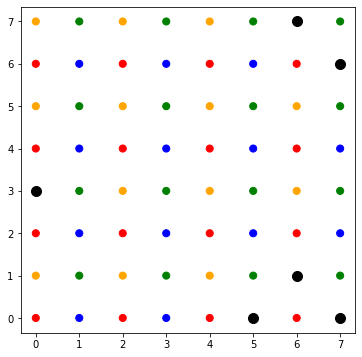

In [11]:
lattice = embed_code((4,4,3,0), 0) 
    
colors = np.empty(lattice.shape, dtype=object)

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            colors[i][j] = "red"
        elif lattice[i][j][0] == "r":
            colors[i][j] = "orange"
        elif lattice[i][j][0] == "l":
            colors[i][j] = "blue"
        else:
            colors[i][j] = "green"

qbts = np.array([None for i in range(2*m*ell)])
for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
            qbts[int(lattice[i][j][1:])] = (i, j)


nodes = itertools.product(np.arange(lattice.shape[0]), np.arange(lattice.shape[1]))

gen_qbts = qbts[np.where(Hx[1])[0]]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(*zip(*nodes), s=50, c=colors.flatten()) # vv qubits
ax.scatter(*zip(*gen_qbts), s=100, c='k')

(array([0.7       , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.11111111,
        0.15555556, 0.        , 0.        , 0.03333333]),
 array([ 9.61769203, 10.69088362, 11.7640752 , 12.83726679, 13.91045838,
        14.98364996, 16.05684155, 17.13003314, 18.20322472, 19.27641631,
        20.3496079 , 21.42279948, 22.49599107, 23.56918266, 24.64237424,
        25.71556583, 26.78875742, 27.861949  , 28.93514059, 30.00833218]),
 <BarContainer object of 19 artists>)

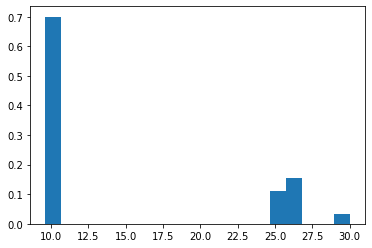

In [210]:
rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    rs.append(make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    rs.append(make_circle(gen_qbts)[2])

bins = np.linspace(min(rs), max(rs), 20)
counts, _ = np.histogram(rs, bins=bins)
counts_weighter = counts.sum()
plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter)
# print(rs)

In [204]:
rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    rs.append(make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    rs.append(make_circle(gen_qbts)[2])

# bins = np.linspace(min(rs), max(rs), 20)
# counts, _ = np.histogram(rs, bins=bins)
# counts_weighter = counts.sum()
# plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter)
print(rs)

[30.008332176247315, 29.508474576271187, 29.508474576271187, 29.508474576271187, 29.508474576271187, 29.508474576271187, 10.514000190222559, 10.51189802081432, 9.617692030835673, 9.617692030835673, 9.617692030835673, 9.617692030835673, 10.514000190222559, 10.51189802081432, 9.617692030835673, 9.617692030835673, 9.617692030835673, 9.617692030835673, 10.514000190222559, 10.51189802081432, 9.617692030835673, 9.617692030835673, 9.617692030835673, 9.617692030835673, 10.514000190222559, 10.51189802081432, 9.617692030835673, 9.617692030835673, 9.617692030835673, 9.617692030835673, 10.514000190222559, 10.51189802081432, 9.617692030835673, 9.617692030835673, 9.617692030835673, 9.617692030835673, 10.514000190222559, 10.51189802081432, 9.617692030835673, 9.617692030835673, 9.617692030835673, 9.617692030835673, 10.514000190222559, 10.51189802081432, 9.617692030835673, 9.617692030835673, 9.617692030835673, 9.617692030835673, 10.514000190222559, 10.51189802081432, 9.617692030835673, 9.61769203083567

(array([0.375 , 0.    , 0.    , 0.    , 0.1875, 0.    , 0.    , 0.    ,
        0.1875, 0.    , 0.125 , 0.    , 0.    , 0.0625, 0.    , 0.    ,
        0.    , 0.    , 0.0625]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

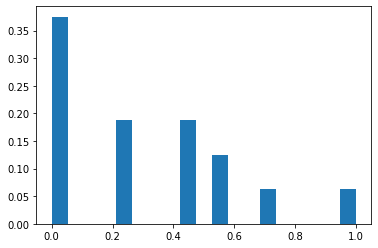

In [135]:
rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    rs.append(make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    rs.append(make_circle(gen_qbts)[2])
    
scaled_rs = [(r - min(rs)) / (max(rs) - min(rs)) for r in rs]

bins = np.linspace(min(scaled_rs), max(scaled_rs), 20)
counts, _ = np.histogram(scaled_rs, bins=bins)
counts_weighter = counts.sum()
plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter)

In [136]:
sum([x*y for x,y in zip(counts/counts_weighter, bins[:-1])])

0.28618421052631576

In [115]:
n = 4
for combination in itertools.product(range(1, n + 1), repeat=3):
    var1, var2, var3 = combination
    # Do something with var1, var2, and var3

In [158]:
lattice

array([['x15', 'r19', 'x11', 'r31', 'x7', 'r27', 'x3', 'r23'],
       ['l12', 'z16', 'l8', 'z28', 'l4', 'z24', 'l0', 'z20'],
       ['x0', 'r20', 'x12', 'r16', 'x8', 'r28', 'x4', 'r24'],
       ['l1', 'z21', 'l13', 'z17', 'l9', 'z29', 'l5', 'z25'],
       ['x5', 'r25', 'x1', 'r21', 'x13', 'r17', 'x9', 'r29'],
       ['l6', 'z26', 'l2', 'z22', 'l14', 'z18', 'l10', 'z30'],
       ['x10', 'r30', 'x6', 'r26', 'x2', 'r22', 'x14', 'r18'],
       ['l11', 'z31', 'l7', 'z27', 'l3', 'z23', 'l15', 'z19']],
      dtype=object)